Tensorflow version 2.11

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from tensorflow.keras.callbacks import EarlyStopping
# from textpreprocessor import TextPreprocessor
import joblib, os
import pandas as pd
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
# Initialize the Text Pre Processor class
# processor = TextPreprocessor()

INPUT_DIR = "../Output/proto_models_rev2"
X_train_pad = joblib.load(os.path.join(INPUT_DIR, 'X_train_pad.pkl'))
X_test_pad = joblib.load(os.path.join(INPUT_DIR, 'X_test_pad.pkl'))

# Load data
df_train = pd.read_csv(os.path.join(INPUT_DIR, 'train_cleaned.csv'))
df_test = pd.read_csv(os.path.join(INPUT_DIR, 'test_cleaned.csv'))
# df_test = processor.load_data()

y_train = df_train['polarity']
y_test = df_test['polarity']

In [14]:
# Define Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=2,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the weights of the best epoch
)

Model Accuracy: 80.25% (with 10000 sample)
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.74      0.77       893
           1       0.80      0.86      0.83      1107

    accuracy                           0.80      2000
   macro avg       0.80      0.80      0.80      2000
weighted avg       0.80      0.80      0.80      2000

In [22]:
# RNN Model Building
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128))
model.add(SimpleRNN(64))  # Using a Simple RNN layer
model.add(Dense(1, activation='sigmoid'))  # Binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
hist = model.fit(X_train_pad, y_train, epochs=20, batch_size=256, validation_data=(X_test_pad, y_test), callbacks= early_stopping)
# Evaluate the model
y_pred_prob = model.predict(X_test_pad)
y_pred = (y_pred_prob > 0.5).astype("int32")
# Model evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:\n", classification_report(y_test, y_pred))

Epoch 1/20
40/40 [==============================] - 11s 268ms/step - loss: 0.6698 - accuracy: 0.5760 - val_loss: 0.6533 - val_accuracy: 0.6140
Epoch 2/20
40/40 [==============================] - 10s 241ms/step - loss: 0.5314 - accuracy: 0.8081 - val_loss: 0.4890 - val_accuracy: 0.7850
Epoch 3/20
40/40 [==============================] - 9s 233ms/step - loss: 0.2604 - accuracy: 0.9196 - val_loss: 0.4360 - val_accuracy: 0.8020
Epoch 4/20
40/40 [==============================] - 9s 232ms/step - loss: 0.0973 - accuracy: 0.9808 - val_loss: 0.4646 - val_accuracy: 0.7990
Epoch 5/20
63/63 [==============================] - 2s 37ms/step
Model Accuracy: 80.25%
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.74      0.77       893
           1       0.80      0.86      0.83      1107

    accuracy                           0.80      2000
   macro avg       0.80      0.80      0.80      2000
weighted avg       0.80      0.80      0.80   

running time 360m
{'rnn_units': 32, 'optimizer': 'rmsprop', 'epochs': 10, 'embedding_dim': 16, 'batch_size': 16}

In [4]:
def build_rnn_model(input_dim, output_dim=1, rnn_units=32, embedding_dim=32, input_length=222, optimizer='adam'):
    model = Sequential()
    model.add(Embedding(input_dim=5000, output_dim=output_dim))
    model.add(SimpleRNN(rnn_units))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

input_dim = 5000  
input_length = 222  
model = KerasClassifier(
    build_fn=build_rnn_model,  
    input_dim=input_dim,
    input_length=input_length,
    verbose=0 
)

param_dist = {
    'rnn_units': [16, 32, 64],     
    'embedding_dim': [16, 32, 64],  
    'optimizer': ['adam', 'rmsprop'], 
    'epochs': [5, 10],                
    'batch_size': [16, 32]          
}

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=10, 
    cv=3,       
    verbose=0,
    n_jobs=4,  
    random_state=42
)

random_search.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test))

print(f"Best parameters found: {random_search.best_params_}")
best_model = random_search.best_estimator_

/tmp/ipykernel_38637/1692542837.py:14: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(
2024-10-11 19:04:18.257226: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-11 19:04:18.273484: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-11 19:04:18.288638: I tensorflow/core/platform/cp

Best parameters found: {'rnn_units': 16, 'optimizer': 'adam', 'epochs': 5, 'embedding_dim': 16, 'batch_size': 16}


In [6]:
def build_rnn_model(input_dim, output_dim=1, rnn_units=32, embedding_dim=32, input_length=222, optimizer='adam'):
    model = Sequential()
    model.add(Embedding(input_dim=5000, output_dim=output_dim))
    model.add(SimpleRNN(rnn_units))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

input_dim = 5000 
input_length = 222  
model = KerasClassifier(
    build_fn=build_rnn_model, 
    input_dim=input_dim,
    input_length=input_length,
    verbose=0 
)

param_grid = {
    'rnn_units': [8, 16, 24],         
    'embedding_dim': [16],        
    'optimizer': ['rmsprop'],  
    'epochs': [2, 5, 7],           
    'batch_size': [8, 16, 32]        
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=3,       
    verbose=0,
    n_jobs=4,  
)

grid_search.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test))

print(f"Best parameters found by GridSearchCV: {grid_search.best_params_}")
best_model = grid_search.best_estimator_

2024-10-11 22:31:56.284277: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-11 22:31:56.643361: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/x86_64-linux-gnu:/usr/local/cuda-12.3/lib64:/usr/local/cuda-12.3/lib64:/usr/local/cuda-11.8/lib64
2024-10-11 22:31:56.643412: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/x86_64-linux-g

Best parameters found by GridSearchCV: {'batch_size': 32, 'embedding_dim': 16, 'epochs': 2, 'optimizer': 'rmsprop', 'rnn_units': 16}


In [8]:
import pickle

best_params_path = os.path.join(INPUT_DIR, 'rnn_best_params.pkl')
best_model_path = os.path.join(INPUT_DIR, 'rnn_best_model.pkl')
grid_search_path = os.path.join(INPUT_DIR, 'rnn_grid_search.pkl')

with open(best_params_path, 'wb') as file:
    pickle.dump(grid_search.best_params_, file)

with open(best_model_path, 'wb') as file:
    pickle.dump(grid_search.best_estimator_, file)

with open(grid_search_path, 'wb') as file:
    pickle.dump(grid_search, file)

print("Best parameters, model, and GridSearchCV object have been saved.")


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......embedding
.........vars
............0
......simple_rnn
.........cell
............vars
...............0
...............1
...............2
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........2
.........3
.........4
.........5
.........6
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2024-10-11 22:37:12         2147
metadata.json                                  2024-10-11 22:37:12           64
variables.h5                                   2024-10-11 22:37:12        66400
Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
........

In [ ]:

with open(best_params_path, 'rb') as file:
    best_params = pickle.load(file)

print("Loaded Best Parameters:", best_params)

In [23]:

def build_rnn_model(input_dim, output_dim=1, rnn_units=32, embedding_dim=32, input_length=222, optimizer='adam'):
    model = Sequential([
        Embedding(input_dim=input_dim, output_dim=embedding_dim, input_length=input_length),
        SimpleRNN(rnn_units),
        Dense(output_dim, activation='sigmoid')
    ])
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

input_dim = 5000  
input_length = 222  
searched_model = KerasClassifier(
    build_fn=build_rnn_model,
    input_dim=input_dim,
    input_length=input_length,
    rnn_units=grid_search.best_params_['rnn_units'],       
    embedding_dim=grid_search.best_params_['embedding_dim'],
    optimizer=grid_search.best_params_['optimizer'],
    epochs=grid_search.best_params_['epochs'] +10,
    batch_size=grid_search.best_params_['batch_size'],
    verbose=1
)

print("New model created with best parameters.")

New model created with best parameters.


/tmp/ipykernel_38637/3066038226.py:14: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  searched_model = KerasClassifier(


Model Accuracy: 83.00% (With 10000 sample)
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.80      0.81       893
           1       0.84      0.86      0.85      1107

    accuracy                           0.83      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.83      0.83      0.83      2000

In [24]:
# Train the model
history = searched_model.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test), callbacks= early_stopping)
# Evaluate the model
y_pred_prob = searched_model.predict(X_test_pad)
y_pred = (y_pred_prob > 0.5).astype("int32")
# Model evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:\n", classification_report(y_test, y_pred))

Epoch 1/12
313/313 [==============================] - 68s 217ms/step - loss: 0.5654 - accuracy: 0.7035 - val_loss: 0.4990 - val_accuracy: 0.7565
Epoch 2/12
313/313 [==============================] - 65s 207ms/step - loss: 0.3706 - accuracy: 0.8373 - val_loss: 0.3826 - val_accuracy: 0.8300
Epoch 3/12
313/313 [==============================] - 65s 209ms/step - loss: 0.2853 - accuracy: 0.8814 - val_loss: 0.4143 - val_accuracy: 0.8230
Epoch 4/12
63/63 [==============================] - 2s 32ms/step
Model Accuracy: 83.00%
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.80      0.81       893
           1       0.84      0.86      0.85      1107

    accuracy                           0.83      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.83      0.83      0.83      2000



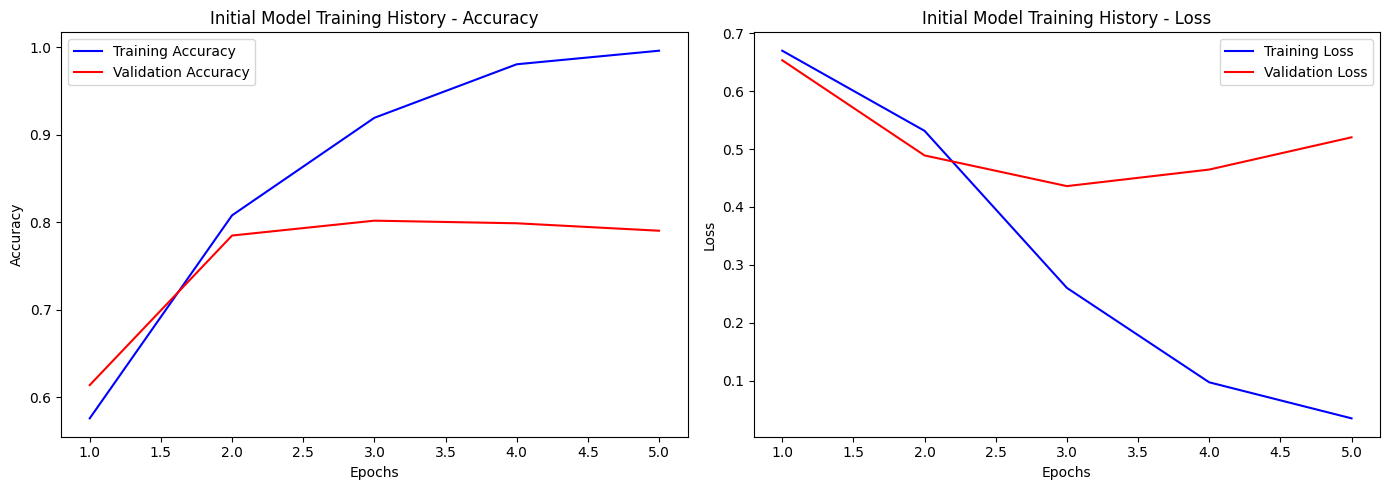

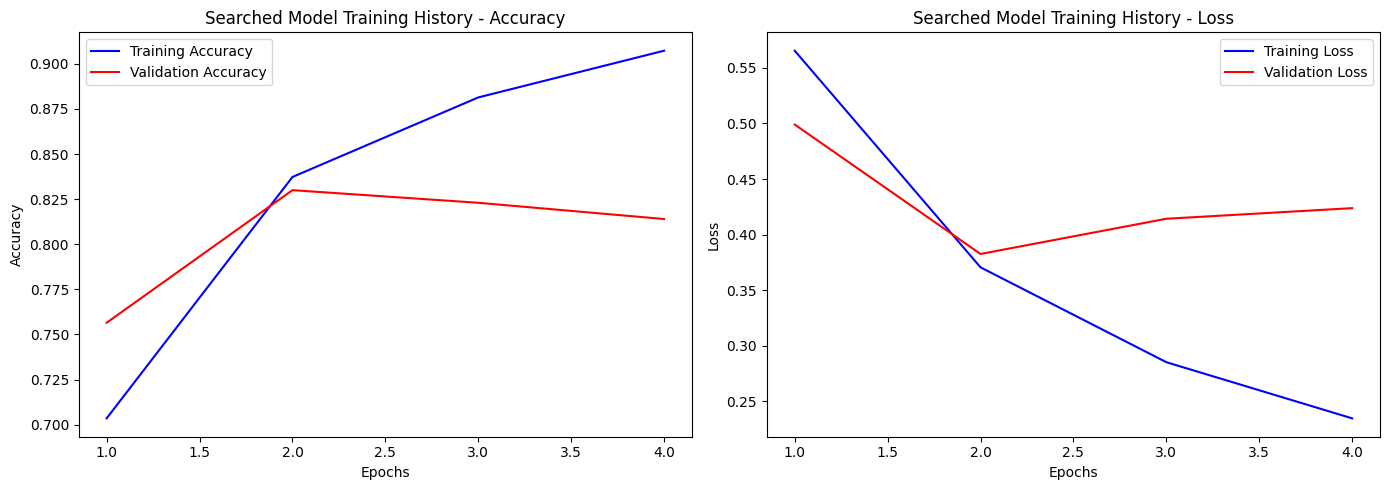

In [25]:
import matplotlib.pyplot as plt

# Define a function to plot training history
def plot_training_history(history, title="Model Training History"):
    # Extract values from history
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(acc) + 1)
    
    # Plot training and validation accuracy
    plt.figure(figsize=(14, 5))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title(f"{title} - Accuracy")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title(f"{title} - Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot for hist
plot_training_history(hist, title="Initial Model Training History")

# Plot for history
plot_training_history(history, title="Searched Model Training History")